In [5]:
import torch
from squeeze_pose_net import SqueezePoseNet
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import torch.optim as optim
import numpy as np
import pickle

In [6]:
# data preperation
batch_size = 40
train_test_ratio = 0.85

with open("/home/simon/catkin_ws/src/turtlebot3_gazebo/scripts/data/outside_rotation_256_rgb8.pkl", 'rb') as f:
    data = pickle.load(f)

pose, rng, img = data

ratio_id = int(data[0].shape[0] * train_test_ratio)

train_pose = pose[:ratio_id]
train_img = img[:ratio_id]
test_pose = pose[ratio_id:]
test_img = img[ratio_id:]

train_set = TensorDataset(torch.from_numpy(train_img).float(), torch.from_numpy(train_pose).float())
test_set = TensorDataset(torch.from_numpy(test_img).float(), torch.from_numpy(test_pose).float())

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=10, shuffle=False)

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.cuda.empty_cache()
print('Device: ', device)

epochs = 1000

net = SqueezePoseNet()

net_state = net.state_dict()

pretrained_net = torch.load('/home/simon/catkin_ws/src/turtlebot3_gazebo/scripts/data/squeezenet_weights.pth')
net_state.update(pretrained_net)
net.load_state_dict(net_state)

Device:  cuda


<All keys matched successfully>

In [9]:
net.to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=20, gamma=0.95)
beta = 500

def pq_loss(output: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    assert output.shape == target.shape, "Output and target are not of equal shape"
    output_x = output[:, :2]
    target_x = target[:, :2]
    output_q = output[:, 2]
    target_q = target[:, 2]
    loss = torch.linalg.norm(target_x - output_x, ord=2) + 500 * torch.linalg.norm(target_q - output_q / torch.linalg.norm(output_q, ord=2), ord=2)
    return loss

criterion = pq_loss

epoch_losses = []
total_losses = []
test_losses = []

for epoch in range(epochs):
    net.train()
    batch_loss = []
    for i, (img, pose) in enumerate(train_loader):
        img = img.to(device)
        pose = pose.to(device)

        optimizer.zero_grad()  # zero the gradient buffers
        output = net(img)
        loss = criterion(output, pose)
        loss.backward()
        optimizer.step()  # Does the update
        loss = loss.item()

        total_losses.append(loss)
        batch_loss.append(loss)

    scheduler.step()

    epoch_losses.append(np.mean(batch_loss))
    
    if epoch%10==0:
        for i, (img, pose) in enumerate(test_loader):
            img = img.to(device)
            pose = pose.to(device)

            optimizer.zero_grad()  # zero the gradient buffers
            output = net(img)
            loss = criterion(output, pose)
            loss = loss.item()

            test_losses.append(loss)

        print('------ Epoch ', epoch)
        print('Epoch loss:', epoch_losses[-1])
        # print('Val loss:', val_loss[-1])
        torch.save(net.state_dict(), "SPN2.pt")

------ Epoch  0
Epoch loss: 5773.58927154541
------ Epoch  10
Epoch loss: 5776.84610748291
------ Epoch  20
Epoch loss: 5764.072334289551
------ Epoch  30
Epoch loss: 5779.573188781738


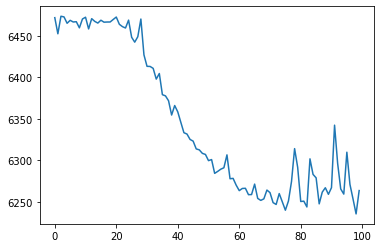

In [ ]:
plt.plot(range(len(epoch_losses)), epoch_losses)

In [ ]:
ranges_max = rng.max()
ranges_min = rng.min()
pose_max = [pose[:, 0].max(), pose[:, 1].max()]
pose_min = [pose[:, 0].min(), pose[:, 1].min()]

def normalize_ranges(ranges_matrix):
    ranges_matrix = (ranges_matrix - ranges_min) / (ranges_max - ranges_min)
    return ranges_matrix
    
def normalize_pos(positions):
    positions[:, 0] = (positions[:, 0] - pose_min[0]) / (pose_max[0] - pose_min[0])
    positions[:, 1] = (positions[:, 1] - pose_min[1]) / (pose_max[1] - pose_min[1])
    # positions[:, 2] = (positions[:, 2] - pose_min[2]) / (pose_max[2] - pose_min[2])
    return positions

def unormalize_ranges(ranges):
    return ranges * (ranges_max - ranges_min) + ranges_min

def unnormalize_pos(positions):
    positions[:, 0] = positions[:, 0] * (pose_max[0] - pose_min[0]) + pose_min[0]
    positions[:, 1] = positions[:, 1] * (pose_max[1] - pose_min[1]) + pose_min[1]
    positions[:, 2] = positions[:, 2] * (pose_max[2] - pose_min[2]) + pose_min[2]
    return positions

train_pose = normalize_pos(train_pose)
train_rng = normalize_ranges(train_rng)
test_pose = normalize_pos(test_pose)
test_rng = normalize_ranges(test_rng)

# Visualizing normalized data
fig, axs = plt.subplots(2)
fig.set_figheight(15)

axs[0].set_title('Sample points ({length})'.format(length=len(pose)))
axs[0].scatter(pose[:, 0], pose[:, 1], s=3)

axs[1].set_title('Ranges distribution')
axs[1].hist(np.concatenate(train_rng).ravel(), bins=100)

plt.show()


TypeError: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'